0. Importing Packages

In [2]:
%pip install -q pandas geopandas numpy matplotlib unicode scipy scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import glob
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from unidecode import unidecode
import matplotlib.colors as mcolors

import zipfile
import os

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score

from matplotlib.colors import ListedColormap

import random


# 1. Cleaning data
## 1.1. Importing datasets

In [43]:
# List of files
data_folder = '../Data'
csv_files = glob.glob(f"{data_folder}/*.csv")

# Read each CSV file into a DataFrame and store in a list
dataframes = [pd.read_csv(file) for file in csv_files]

#IICA files
csv_iica = glob.glob(f"{data_folder}/*IICA/*.csv")
dataframes_iica = [pd.read_csv(file) for file in csv_iica]

#Fiscal performance files
csv_fisc = glob.glob(f"{data_folder}/*Terridata/*.csv")
dataframes_fisc = [pd.read_csv(file) for file in csv_fisc]


## 1.2. Cleaning datasets

In [44]:
#####################
### IICA datasets ###
#####################

### IICA 2002-2013 ###
dataframes_iica[0] = dataframes_iica[0].iloc[:, :5]
dataframes_iica[0] = dataframes_iica[0].rename(columns={
    'divipola': 'Divipola',
    'Departamento': 'Depto',
    'Municipio': 'Municipio',
    'año': 'year',
    'Índice de indicencia del conflicto': 'iica'
})

dataframes_iica[0]

,Divipola,Depto,Municipio,year,iica
0,5001,ANTIOQUIA,MEDELLÍN,2013,0.008261
1,5002,ANTIOQUIA,ABEJORRAL,2013,0.005499
2,5004,ANTIOQUIA,ABRIAQUÍ,2013,0.000327
3,5021,ANTIOQUIA,ALEJANDRÍA,2013,0.005062
4,5030,ANTIOQUIA,AMAGÁ,2013,0.016015
...,...,...,...,...,...
13459,97889,VAUPÉS,YAVARATÉ,2002,0.000185
13460,99001,VICHADA,PUERTO CARREÑO,2002,0.021377
13461,99524,VICHADA,LA PRIMAVERA,2002,0.010955
13462,99624,VICHADA,SANTA ROSALÍA,2002,0.012447


In [45]:
#####################
### IICA datasets ###
#####################

### IICA 2014-2016 ###
dataframes_iica[1] = pd.melt(dataframes_iica[1], id_vars=dataframes_iica[1].columns[:3], value_vars=dataframes_iica[1].columns[3:5], 
                    var_name='year', value_name='iica')

# Extract only the year number from the 'year' column
dataframes_iica[1]['year'] = dataframes_iica[1]['year'].str.extract('(\d+)').astype(int)

dataframes_iica[1]



<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
C:\Users\cpedr\AppData\Local\Temp\ipykernel_19204\3086565869.py:10: SyntaxWarning: invalid escape sequence '\d'
  dataframes_iica[1]['year'] = dataframes_iica[1]['year'].str.extract('(\d+)').astype(int)


,Divipola,Depto,Municipio,year,iica
0,5001,ANTIOQUIA,MEDELLIN,2014,0.00692
1,5002,ANTIOQUIA,ABEJORRAL,2014,0.00738
2,5004,ANTIOQUIA,ABRIAQUI,2014,0.00070
3,5021,ANTIOQUIA,ALEJANDRIA,2014,0.00056
4,5030,ANTIOQUIA,AMAGA,2014,0.00925
...,...,...,...,...,...
2239,97889,VAUPÉS,YAVARATE,2015,0.00000
2240,99001,VICHADA,PUERTO CARREÑO,2015,0.00620
2241,99524,VICHADA,LA PRIMAVERA,2015,0.01250
2242,99624,VICHADA,SANTA ROSALIA,2015,0.00076


In [46]:
### IICA 2017-2022 ###
dataframes_iica[2] = pd.melt(dataframes_iica[2], id_vars=dataframes_iica[2].columns[1:4], value_vars=dataframes_iica[2].columns[4:10], 
                    var_name='year', value_name='iica')

# Extract only the year number from the 'year' column
dataframes_iica[2]['year'] = dataframes_iica[2]['year'].str.extract('(\d+)').astype(int)

dataframes_iica[2]

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
C:\Users\cpedr\AppData\Local\Temp\ipykernel_19204\3795539174.py:6: SyntaxWarning: invalid escape sequence '\d'
  dataframes_iica[2]['year'] = dataframes_iica[2]['year'].str.extract('(\d+)').astype(int)


,Divipola,Municipio,Depto,year,iica
0,5001,MEDELLIN,ANTIOQUIA,2017,0.02816
1,5002,ABEJORRAL,ANTIOQUIA,2017,0.00960
2,5004,ABRIAQUI,ANTIOQUIA,2017,0.03638
3,5021,ALEJANDRIA,ANTIOQUIA,2017,0.03846
4,5030,AMAGA,ANTIOQUIA,2017,0.03954
...,...,...,...,...,...
6721,97889,YAVARATE,VAUPÉS,2022,0.00000
6722,99001,PUERTO CARREÑO,VICHADA,2022,0.06498
6723,99524,LA PRIMAVERA,VICHADA,2022,0.03024
6724,99624,SANTA ROSALIA,VICHADA,2022,0.00344


In [183]:
# Merge all IICA datasets
merged_iica = pd.concat(dataframes_iica, ignore_index=True)

# From 2010 onwards
merged_iica = merged_iica[merged_iica["year"] >= 2010]
merged_iica = merged_iica.rename(columns={
    "Divipola": "codmpio"
})

merged_iica = merged_iica[['codmpio', 'year', 'iica']]
merged_iica

,codmpio,year,iica
0,5001,2013,0.008261
1,5002,2013,0.005499
2,5004,2013,0.000327
3,5021,2013,0.005062
4,5030,2013,0.016015
...,...,...,...
22429,97889,2022,0.000000
22430,99001,2022,0.064980
22431,99524,2022,0.030240
22432,99624,2022,0.003440


In [184]:
##########################
### Fiscal Performance ###
##########################

### New index ###

new_fisc = pd.read_excel("../Data/Terridata/fisc_new.xlsx")
new_fisc

PermissionError: [Errno 13] Permission denied: '../Data/Terridata/fisc_new.xlsx'

In [220]:
### Old Index ###
old_fisc = dataframes_fisc[0][dataframes_fisc[0]['Indicador'] == 'Indicador de desempeño fiscal']
old_fisc['Dato Numérico'] = old_fisc['Dato Numérico'].str.replace(',', '.').astype(float)
old_fisc = old_fisc.iloc[:, [2, 7, 9]]
old_fisc = old_fisc.rename(columns={
    'Código Entidad': 'codmpio',
    'Dato Numérico': 'fisc_perf',
    'Año': 'year', 
})

old_fisc = old_fisc[(old_fisc["year"] >= 2010) & (old_fisc["year"] < 2020)]
old_fisc

C:\Users\cpedr\AppData\Local\Temp\ipykernel_19204\3928155548.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_fisc['Dato Numérico'] = old_fisc['Dato Numérico'].str.replace(',', '.').astype(float)


,codmpio,fisc_perf,year
125,1001.0,NaN,2010.0
126,1001.0,NaN,2011.0
127,1001.0,NaN,2012.0
128,1001.0,NaN,2013.0
129,1001.0,NaN,2014.0
...,...,...,...
166826,99773.0,76.15,2015.0
166827,99773.0,60.25,2016.0
166828,99773.0,55.16,2017.0
166829,99773.0,NaN,2018.0


In [50]:
###########################
### Working the accents ###
###########################

# Function to remove accents while preserving special cases
def remove_accents(input_string):
    if input_string in ["Ñ", "Ü"]:
        return input_string
    return unidecode(input_string)

In [235]:
################
### Divipola ###
################

codes = dataframes[2]
codes = codes.rename(columns={
    'Código Municipio': 'codmpio',
    'Nombre Departamento': 'Departamento',
    'Nombre Municipio': 'Municipio'
})

codes["Departamento"] = codes["Departamento"].apply(remove_accents)
codes["Municipio"] = codes["Municipio"].apply(remove_accents)

codmpios = codes["codmpio"].unique()

codes = codes[['codmpio', 'Departamento', 'Municipio']].drop_duplicates()
codes

,codmpio,Departamento,Municipio
0,5001,ANTIOQUIA,MEDELLIN
55,5002,ANTIOQUIA,ABEJORRAL
64,5004,ANTIOQUIA,ABRIAQUI
66,5021,ANTIOQUIA,ALEJANDRIA
67,5030,ANTIOQUIA,AMAGA
...,...,...,...
9174,97889,VAUPES,YAVARATE
9176,99001,VICHADA,PUERTO CARRENO
9179,99524,VICHADA,LA PRIMAVERA
9186,99624,VICHADA,SANTA ROSALIA


In [227]:
# Merge all fiscal performance datasets
merged_fisc = pd.concat([old_fisc, new_fisc], ignore_index=True)

# Display the merged dataframe
merged_fisc = merged_fisc[merged_fisc["codmpio"].isin(codmpios)]

# Get rid of years before municipality 94343 was founded
merged_fisc = merged_fisc[~((merged_fisc["fisc_perf"].isna()) & (merged_fisc['codmpio'] == 94343))]

# Ensure the data is sorted correctly before interpolation
merged_fisc = merged_fisc.sort_values(by=['codmpio', 'year'])

# Linear Interpolation (between years) for municipalities with random missing values
merged_fisc['fisc_perf'] = merged_fisc.groupby('codmpio')['fisc_perf'].transform(lambda x: x.interpolate())

merged_fisc

,codmpio,fisc_perf,year
18,5001.0,89.430000,2010.0
19,5001.0,84.360000,2011.0
20,5001.0,83.220000,2012.0
21,5001.0,84.820000,2013.0
22,5001.0,85.500000,2014.0
...,...,...,...
11346,99773.0,61.960000,2018.0
11347,99773.0,68.760000,2019.0
13279,99773.0,62.680053,2020.0
14647,99773.0,24.066327,2021.0


In [158]:
###########
### GDP ###
###########

# Read the Excel file
gdp = pd.read_excel("../Data/anex-PIBDep-ValorAgreMuni-2011-2022p.xlsx", 
                    sheet_name="Cuadro 1", skiprows=10, nrows=1122)

# Drop unnecessary columns
gdp = gdp.drop(columns=["Código Departamento", "Departamento", "Municipio ", "Unnamed: 16", "Unnamed: 17"])

# Rename columns
gdp = gdp.rename(columns={
    "Código Municipio": "codmpio",
    "2021p": "2021",
    "2022p": "2022"
})

# Reshape data from wide to long format
gdp = gdp.melt(id_vars=["codmpio"], var_name="year", value_name="gdp")
gdp['gdp'] = gdp['gdp']*1000

gdp


,codmpio,year,gdp
0,5001,2011,3.444253e+07
1,5002,2011,1.271750e+05
2,5004,2011,1.754917e+04
3,5021,2011,8.998268e+04
4,5030,2011,2.169485e+05
...,...,...,...
13459,97889,2022,3.567078e+03
13460,99001,2022,1.777020e+05
13461,99524,2022,2.445231e+05
13462,99624,2022,1.221738e+05


In [159]:
# Old values
gdp_old = dataframes[5][['codmpio', 'ano', 'pib_total']]

# Rename columns
gdp_old = gdp_old.rename(columns={
    "ano": "year",
    "pib_total": "gdp"
})

# Drop NAs
gdp_old = gdp_old.dropna(subset=['gdp'])


In [160]:
# Merge gdp datasets
gdp = pd.concat([gdp, gdp_old], ignore_index=True)

# Identify municipalities that need interpolation
municipalities = gdp["codmpio"].unique()

# Create a new DataFrame for interpolated 2010 values
interpolated_rows = []

for municipality in municipalities:
    # Get GDP values for 2009 and 2011 for the current municipality
    gdp_2009 = gdp[(gdp["codmpio"] == municipality) & (gdp["year"] == 2009)]["gdp"].values
    gdp_2011 = gdp[(gdp["codmpio"] == municipality) & (gdp["year"] == 2011)]["gdp"].values
    
    # Ensure both years exist for interpolation
    if len(gdp_2009) > 0 and len(gdp_2011) > 0:
        # Perform linear interpolation
        gdp_2010 = (gdp_2009[0] + gdp_2011[0]) / 2
        
        # Append interpolated row
        interpolated_rows.append({"codmpio": municipality, "year": 2010, "gdp": gdp_2010})

# Convert interpolated data to DataFrame
gdp_interpolated = pd.DataFrame(interpolated_rows)

# Append interpolated data to the main dataset
gdp = pd.concat([gdp, gdp_interpolated], ignore_index=True)

# Sort dataset by municipality and year
gdp = gdp.sort_values(by=["codmpio", "year"]).reset_index(drop=True)

# Drop duplicates
gdp = gdp.drop_duplicates(subset=["codmpio", "year", "gdp"])

# Subset years
gdp["year"] = gdp["year"].astype(int)
gdp = gdp[gdp["year"] >= 2010]
gdp

,codmpio,year,gdp
10,5001,2010,2.964083e+07
11,5001,2011,3.444253e+07
12,5001,2012,3.692472e+07
13,5001,2013,4.088087e+07
14,5001,2014,4.304234e+07
...,...,...,...
25526,99773,2018,2.728310e+05
25527,99773,2019,2.756950e+05
25528,99773,2020,2.766593e+05
25529,99773,2021,3.169662e+05


In [161]:
###################
### Shape files ###
###################

# Read the shapefile
shapes = gpd.read_file('../Data/shapes/shapes.shp')

# Keep relevant variables
shapes = shapes[["mpios", "geometry"]]

# mpios changes
shapes = shapes.rename(columns={
  "mpios": "codmpio"       
})
shapes["codmpio"] = shapes["codmpio"].astype(int)

# Display the updated shapes dataset to verify the hectares variable
shapes = gpd.GeoDataFrame(shapes, geometry="geometry")
shapes

,codmpio,geometry
0,5873,"POLYGON ((-76.90331 6.83561, -76.90562 6.82957..."
1,5686,"POLYGON ((-75.6099 6.8743, -75.6071 6.8708, -7..."
2,5284,"POLYGON ((-76.2441 6.9174, -76.2227 6.9167, -7..."
3,5315,"POLYGON ((-75.2312 6.9374, -75.2232 6.9287, -7..."
4,68895,"POLYGON ((-73.2425 6.9088, -73.2309 6.9047, -7..."
...,...,...
1117,47205,"POLYGON ((-74.69577 10.22744, -74.69933 10.226..."
1118,47960,"POLYGON ((-74.70518 10.27644, -74.69872 10.263..."
1119,17380,"POLYGON ((-74.6766 5.7584, -74.6754 5.7463, -7..."
1120,27150,"POLYGON ((-76.89271 7.24821, -76.89113 7.22927..."


In [162]:
################################
### Deforestation with codes ###
################################
deforestation = dataframes[1]

# Apply function to remove accents
deforestation["subnational1"] = deforestation["subnational1"].str.upper().apply(remove_accents)
deforestation["subnational2"] = deforestation["subnational2"].str.upper().apply(remove_accents)

# Finding non-matching names: towns
non_matching_towns = set(codes["subnational2"]) - set(deforestation["subnational2"])
print(len(non_matching_towns))  # 88 do not match
print(len(set(codes["subnational2"])) - len(set(deforestation["subnational2"])))
print(non_matching_towns)

# Finding non-matching names: departments
non_matching_departments = set(codes["subnational1"]) - set(deforestation["subnational1"])
print(len(non_matching_departments))  # 2 do not match
print(len(set(codes["subnational1"])) - len(set(deforestation["subnational1"])))
print(non_matching_departments)

# Manually updating values
replace_dict_subnational1 = {
    ("CUNDINAMARCA", "SANTAFE DE BOGOTA"): "BOGOTA, D.C.",
    "SAN ANDRES Y PROVIDENCIA": "ARCHIPIELAGO DE SAN ANDRES, PROVIDENCIA Y SANTA CATALINA"
}

replace_dict_subnational2 = {
    ("ANTIOQUIA", "BOLIVAR"): "CIUDAD BOLIVAR",
    ("ANTIOQUIA", "CAROLINA DEL PRINCIPE"): "CAROLINA",
    "DON MATIAS": "DONMATIAS",
    "LA UNION DE SUCRE": "LA UNION",
    "SAN VICENTE": "SAN VICENTE FERRER",
    "SANTAFE DE BOGOTA": "BOGOTA, D.C.",
    "SAN ESTANISLAO DE KOSTKA": "SAN ESTANISLAO",
    ("BOYACA", "CIENAGA"): "CIENEGA",
    "GUICAN": "GÜICAN",
    "TOGUI": "TOGÜI",
    ("CESAR", "MANAURE"): "MANAURE BALCON DEL CESAR",
    "SANTA CRUZ DE LORICA": "LORICA",
    "PURISIMA": "PURISIMA DE LA CONCEPCION",
    "SAN BERNARDINO DE SAHAGUN": "SAHAGUN",
    "SAN JUAN DE RIO SECO": "SAN JUAN DE RIOSECO",
    "SANTA MARTA (DIST. ESP.)": "SANTA MARTA",
    "PUEBLO VIEJO": "PUEBLOVIEJO",
    "LA URIBE": "URIBE",
    "VISTA HERMOSA": "VISTAHERMOSA",
    "SAN JUAN DE PASTO": "PASTO",
    "SANTA CRUZ": "SANTACRUZ",
    "TUMACO": "SAN ANDRES DE TUMACO",
    "SAN JOSE DE CUCUTA": "CUCUTA",
    "LA PLAYA DE BELEN": "LA PLAYA",
    "SALAZAR DE LAS PALMAS": "SALAZAR",
    "SANTO DOMINGO DE SILOS": "SILOS",
    "SAN ANTONIO DE PALMITO": "PALMITO",
    "SINCE": "SAN LUIS DE SINCE",
    "TOLU": "SANTIAGO DE TOLU",
    "TOLUVIEJO": "TOLU VIEJO",
    "ARMERO": "ARMERO GUAYABAL",
    "SANTIAGO DE CALI": "CALI",
    "SAN MIGUEL DE MOCOA": "MOCOA",
    "MIRITI-PARANA": "MIRITI - PARANA",
    "PUERTO INIRIDA": "INIRIDA",
    "PAPUNAHUA": "PAPUNAUA"
}

deforestation["subnational1"] = deforestation.apply(
    lambda row: replace_dict_subnational1.get((row["subnational1"], row["subnational2"]), 
                                              replace_dict_subnational1.get(row["subnational1"], row["subnational1"])), axis=1
)

deforestation["subnational2"] = deforestation.apply(
    lambda row: replace_dict_subnational2.get((row["subnational1"], row["subnational2"]), 
                                              replace_dict_subnational2.get(row["subnational2"], row["subnational2"])), axis=1
)

# Merge datasets
def_codes = pd.merge(deforestation, codes, on=["subnational1", "subnational2"])

def_codes


52
49
{'SITIONUEVO', 'SAN JOSE', 'ALGARROBO', 'COTORRA', 'CERTEGUI', 'UNION PANAMERICANA', 'DIBULLA', 'SAN JACINTO DEL CAUCA', 'SAN JOSE DE URE', 'EL ROBLE', 'ARENAL', 'HATONUEVO', 'RIO QUITO', 'RIO IRO', 'MEDIO BAUDO', 'ZONA BANANERA', 'CARMEN DEL DARIEN', 'LA APARTADA', 'REGIDOR', 'PUEBLO BELLO', 'NOROSI', 'MEDIO SAN JUAN', 'ARROYOHONDO', 'EL ROSAL', 'PIAMONTE', 'NORCASIA', 'COVENAS', 'ATRATO', 'SANTA BARBARA DE PINTO', 'EL RETEN', 'LA JAGUA DEL PILAR', 'MAGANGUE', 'MAPIRIPANA', 'TIQUISIO', 'EL PENOL', 'SABANAS DE SAN ANGEL', 'SAN CRISTOBAL', 'DISTRACCION', 'SOLITA', 'VILLA RICA', 'MEDIO ATRATO', 'NUEVA GRANADA', 'PUERTO ARICA', 'CLEMENCIA', 'TUCHIN', 'ZAPAYAN', 'GUACHENE', 'PALOCABILDO', 'PIJINO DEL CARMEN', 'PUERTO ALEGRIA', 'MORICHAL', 'LA PINTADA'}
0
0
set()


,country,subnational1,subnational2,threshold,area_ha,extent_2000_ha,extent_2010_ha,gain_2000-2020_ha,tc_loss_ha_2001,tc_loss_ha_2002,...,tc_loss_ha_2018,tc_loss_ha_2019,tc_loss_ha_2020,tc_loss_ha_2021,tc_loss_ha_2022,tc_loss_ha_2023,Código Departamento,codmpio,Código Centro Poblado,Nombre Centro Poblado
0,Colombia,AMAZONAS,EL ENCANTO,0,1027642,1027642,1027642,773,212,182,...,178,219,392,299,334,224,91,91263,91263000,EL ENCANTO
1,Colombia,AMAZONAS,EL ENCANTO,10,1027642,1010468,1010236,773,212,182,...,176,218,386,295,320,217,91,91263,91263000,EL ENCANTO
2,Colombia,AMAZONAS,EL ENCANTO,15,1027642,1010422,1010189,773,212,182,...,176,218,386,295,320,217,91,91263,91263000,EL ENCANTO
3,Colombia,AMAZONAS,EL ENCANTO,20,1027642,1010269,1010088,773,212,182,...,176,217,386,295,319,217,91,91263,91263000,EL ENCANTO
4,Colombia,AMAZONAS,EL ENCANTO,25,1027642,1010200,1010045,773,212,182,...,176,217,386,294,319,217,91,91263,91263000,EL ENCANTO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69915,Colombia,VICHADA,SANTA ROSALIA,30,432087,41681,43871,6493,75,120,...,28,27,43,78,31,36,99,99624,99624001,GUACACÍAS
69916,Colombia,VICHADA,SANTA ROSALIA,50,432087,36801,36327,6493,66,110,...,25,27,42,77,29,31,99,99624,99624000,SANTA ROSALÍA
69917,Colombia,VICHADA,SANTA ROSALIA,50,432087,36801,36327,6493,66,110,...,25,27,42,77,29,31,99,99624,99624001,GUACACÍAS
69918,Colombia,VICHADA,SANTA ROSALIA,75,432087,30129,28283,6493,53,99,...,23,24,38,67,24,25,99,99624,99624000,SANTA ROSALÍA


In [163]:
#####################
### Deforestation ###
#####################

# Select only numeric columns
numeric_cols = def_codes.select_dtypes(include=[np.number]).columns

# Group by 'subnational1' and 'subnational2' and calculate the mean for tree cover loss for all thresholds
def_codes = def_codes.groupby(['subnational1', 'subnational2'])[numeric_cols].mean()
def_codes.reset_index(inplace=True)
def_codes = def_codes.iloc[:, list(range(0, 2)) + list(range(7, def_codes.shape[1]))]

# Wide to long
def_codes = pd.melt(def_codes, id_vars=list(def_codes.columns[[0, 1, 26]]), value_vars=def_codes.columns[2:25], 
                    var_name='year', value_name='tc_loss')

# Extract only the year number from the 'year' column
def_codes['year'] = def_codes['year'].str.extract('(\d+)')
# Drop rows with NaN values in the 'year' column
def_codes = def_codes.dropna(subset=['year'])

# Convert the 'year' column to integers
def_codes['year'] = def_codes['year'].astype(int)


def_codes


<>:18: SyntaxWarning: invalid escape sequence '\d'
<>:18: SyntaxWarning: invalid escape sequence '\d'
C:\Users\cpedr\AppData\Local\Temp\ipykernel_19204\154202201.py:18: SyntaxWarning: invalid escape sequence '\d'
  def_codes['year'] = def_codes['year'].str.extract('(\d+)')


,subnational1,subnational2,codmpio,year,tc_loss
0,AMAZONAS,EL ENCANTO,91263.0,2001,212.000
1,AMAZONAS,LA CHORRERA,91405.0,2001,285.000
2,AMAZONAS,LA PEDRERA,91407.0,2001,139.000
3,AMAZONAS,LETICIA,91001.0,2001,180.750
4,AMAZONAS,MIRITI - PARANA,91460.0,2001,125.000
...,...,...,...,...,...
24352,VAUPES,YAVARATE,97889.0,2023,229.000
24353,VICHADA,CUMARIBO,99773.0,2023,1401.125
24354,VICHADA,LA PRIMAVERA,99524.0,2023,338.125
24355,VICHADA,PUERTO CARRENO,99001.0,2023,199.500


In [164]:
###############################
### General Characteristics ###
###############################
general = dataframes[5][["codmpio", "ano", "gandina", "gcaribe", "gpacifica", "gorinoquia", "gamazonia",
                         "areaoficialhm2", "discapital", "dismdo", "disbogota", "pobl_rur", "pobl_urb"]]

# Identify dummy columns starting with 'g'
dummy_cols = [col for col in general.columns if col.startswith("g")]

# Convert dummies to a single categorical column
general['Region'] = general[dummy_cols].idxmax(axis=1).str.replace("g", "").str.capitalize()

# Drop the original dummy columns
general = general.drop(columns=dummy_cols)

# Convert to categorical type if needed
general['Region'] = general['Region'].astype('category')

# Subset years
general = general.rename(columns={
    "ano": "year"
})
general = general[general["year"] >= 2010]

# Fix vars as numeric
general["pobl_rur"] = general["pobl_rur"].str.replace(",", "").astype(int)
general["pobl_urb"] = general["pobl_urb"].str.replace(",", "").astype(int)

general

C:\Users\cpedr\AppData\Local\Temp\ipykernel_19204\1699620150.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general['Region'] = general[dummy_cols].idxmax(axis=1).str.replace("g", "").str.capitalize()


,codmpio,year,areaoficialhm2,discapital,dismdo,disbogota,pobl_rur,pobl_urb,Region
17,5001,2010,38700,0,0.0,264,33603,2309446,Andina
18,5001,2011,38700,0,0.0,264,32714,2335568,Andina
19,5001,2012,38700,0,0.0,264,31877,2361134,Andina
20,5001,2013,38700,0,0.0,264,31092,2386233,Andina
21,5001,2014,38700,0,0.0,264,30358,2410765,Andina
...,...,...,...,...,...,...,...,...,...
34772,99773,2019,6567400,92,NaN,594,73053,3143,Orinoquia
34773,99773,2020,6567400,92,NaN,594,75490,3373,Orinoquia
34774,99773,2021,6567400,92,NaN,594,76648,3336,Orinoquia
34775,99773,2022,6567400,92,NaN,594,77681,3156,Orinoquia


In [165]:
#####################
### DNP variables ###
#####################
dnp = pd.read_excel("../Data/dnp&conflict.xlsx", sheet_name="dnp")


dnp

PermissionError: [Errno 13] Permission denied: '../Data/dnp&conflict.xlsx'

In [ ]:
### Conflic CEDE ###
conflict = pd.read_excel("../Data/dnp&conflict.xlsx", sheet_name="conflict")

conflict = conflict.fillna(0)

conflict

,codmpio,year,H_coca,errad_manual,terrorismot,pirateria_terr,e_amenaza,e_confina,e_delito_sex,e_desap_for,e_desplaza,e_minas_anti,e_tortura,e_vinc_mened,eventos_minas
0,5001,2010,0.00,0.000000,9.0,49.0,823.0,0.0,10.0,39.0,12033.0,0.0,4.0,8.0,3.0
1,5001,2011,0.00,0.000000,13.0,58.0,1393.0,0.0,33.0,34.0,18471.0,0.0,0.0,4.0,1.0
2,5001,2012,0.00,0.000000,19.0,62.0,7212.0,0.0,23.0,19.0,18094.0,1.0,4.0,9.0,3.0
3,5001,2013,0.00,0.000000,12.0,61.0,3936.0,0.0,31.0,0.0,12315.0,2.0,4.0,0.0,1.0
4,5001,2014,0.00,0.000000,0.0,16.0,2927.0,0.0,27.0,0.0,8872.0,0.0,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15705,99773,2019,245.30,308.270000,0.0,0.0,80.0,0.0,4.0,0.0,302.0,0.0,0.0,0.0,3.0
15706,99773,2020,120.98,203.978900,1.0,0.0,44.0,0.0,2.0,0.0,94.0,0.0,0.0,0.0,0.0
15707,99773,2021,310.83,52.751099,0.0,0.0,42.0,0.0,2.0,0.0,192.0,0.0,0.0,2.0,0.0
15708,99773,2022,282.70,0.000000,0.0,0.0,110.0,0.0,4.0,0.0,192.0,0.0,2.0,0.0,0.0


In [166]:
############
### Agro ###
############

agro = dataframes[0]

# Drop columns with only missing values
agro = agro.dropna(axis=1, how="all")

# Drop rows with missing values for all columns for 17th column onwards
agro = agro[~agro[agro.columns[2:]].isna().all(axis=1)]

# Fill missing values with 0
agro.fillna(0, inplace=True)

# Dictionary of prefixes and their corresponding total column names
prefixes = {
    "ac_": "total_ac",  # Harvested area
    "as_": "total_as",  # Sowed area
    "p_": "total_p",    # Production
    "r_": "total_r",    # Performance
    "nuf_": "total_nuf", # Number of credits
    "vrf_": "total_vrf"  # Value of credits
}

# Create new columns with the sum for each variable group
for prefix, total_col in prefixes.items():
    agro[total_col] = agro.filter(like=prefix).sum(axis=1)

# Drop rows with 0 for all the total columns
agro = agro[agro[list(prefixes.values())].sum(axis=1) > 0]

# Keep the first two columns + the total ones
columns_to_keep = list(agro.columns[:2]) + [col for col in agro.columns if col.startswith("total_")]

agro = agro[columns_to_keep]
agro = agro.rename(columns={
    "ano": "year"
})

agro = agro[agro["year"] >= 2010]

agro

,codmpio,year,total_ac,total_as,total_p,total_r,total_nuf,total_vrf
7,5001,2010,2099.0,2215.0,13638.0,469.0,503.0,68340.0
8,5001,2011,2094.0,2238.0,16880.0,441.0,458.0,137060.0
9,5001,2012,2198.0,2298.0,18119.0,447.0,499.0,203706.0
10,5001,2013,1671.0,1833.0,17491.0,447.0,468.0,350312.0
11,5001,2014,1610.0,1806.0,17748.0,447.0,482.0,367059.0
...,...,...,...,...,...,...,...,...
23285,99773,2019,2858.0,3695.0,23280.0,144.0,80.0,1622.0
23286,99773,2020,2526.0,3477.0,11347.0,33.0,164.0,3036.0
23287,99773,2021,2873.0,3095.0,16705.0,95.0,127.0,7822.0
23288,99773,2022,2973.0,3079.0,19521.0,158.0,129.0,10643.0


In [ ]:
### Merge all ###
final_df = pd.merge(codes, merged_iica, on="codmpio", how="left")
final_df = pd.merge(final_df, shapes, on="codmpio", how="left")
final_df = pd.merge(final_df, merged_fisc, on=["codmpio", "year"], how="left")
final_df = pd.merge(final_df, gdp, on=["codmpio", "year"], how="left")
final_df = pd.merge(final_df, general, on=["codmpio", "year"], how="left")

# Ged GDP per capita
final_df["gdp_pc"] = final_df["gdp"] / (final_df["pobl_rur"] + final_df["pobl_urb"]) # Times 1 million 

# Keep merging
final_df = pd.merge(final_df, agro, on=["codmpio", "year"], how="left")
final_df = pd.merge(final_df, conflict, on=["codmpio", "year"], how="left")
final_df = pd.merge(final_df, dnp, on=["codmpio", "year"], how="left")

# Work with deforestation variable
final_df = final_df.rename(columns={
    "M-03-25": "f_loss"
})

final_df["pc_loss"] = (final_df["f_loss"] / final_df["areaoficialhm2"])*100

# Reorganize variables
selected_columns = ["codmpio", "Departamento", "Municipio", "Region", "geometry", "year", "f_loss", "pc_loss", "areaoficialhm2", "gdp", "gdp_pc"]  

# Reorder the dataset: Keep selected columns first, then the rest
remaining_columns = [col for col in final_df.columns if col not in selected_columns]
new_column_order = selected_columns + remaining_columns  

# Apply the new column order
final_df = final_df[new_column_order]

# Sort the dataset by `codmpio` and `year`
final_df = final_df.sort_values(by=["codmpio", "year"]).reset_index(drop=True)

final_df = gpd.GeoDataFrame(final_df, geometry="geometry")

final_df


,codmpio,Departamento,Municipio,Region,geometry,year,f_loss,pc_loss,areaoficialhm2,gdp,...,P-01-25,PCC-01-2,PCC-02-1,C-03-14,PCC-02-3,PCC-02-3a,PCC-02-4,C-03-13,P-01-46,P-01-34-1
0,5001,ANTIOQUIA,MEDELLIN,Andina,"POLYGON ((-75.6754 6.3812, -75.6754 6.3749, -7...",2010,30.154418,0.077918,38700,2.964083e+07,...,1,45.165549,100.0,12.590432,99.751839,100.000000,50.000000,1,1.217692,4
1,5001,ANTIOQUIA,MEDELLIN,Andina,"POLYGON ((-75.6754 6.3812, -75.6754 6.3749, -7...",2011,25.695615,0.066397,38700,3.444253e+07,...,1,45.245880,100.0,12.920759,99.751839,100.000000,50.000000,1,1.217692,4
2,5001,ANTIOQUIA,MEDELLIN,Andina,"POLYGON ((-75.6754 6.3812, -75.6754 6.3749, -7...",2012,29.345245,0.075828,38700,3.692472e+07,...,1,46.737400,100.0,11.617163,99.751839,100.000000,50.000000,1,1.217692,4
3,5001,ANTIOQUIA,MEDELLIN,Andina,"POLYGON ((-75.6754 6.3812, -75.6754 6.3749, -7...",2013,18.412226,0.047577,38700,4.088087e+07,...,1,50.976367,100.0,12.658621,99.751839,100.000000,50.000000,1,1.217692,4
4,5001,ANTIOQUIA,MEDELLIN,Andina,"POLYGON ((-75.6754 6.3812, -75.6754 6.3749, -7...",2014,43.509827,0.112428,38700,4.304234e+07,...,1,49.602144,100.0,11.879778,89.775347,90.355662,45.177831,1,1.217692,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13477,99773,VICHADA,CUMARIBO,Orinoquia,"POLYGON ((-68.5412 5.437, -68.5118 5.4467, -68...",2018,5986.956176,0.091162,6567400,2.728310e+05,...,5,0.001109,0.0,0.000000,0.185979,1.158266,40.105233,1,3.078961,1
13478,99773,VICHADA,CUMARIBO,Orinoquia,"POLYGON ((-68.5412 5.437, -68.5118 5.4467, -68...",2019,5318.000000,0.080976,6567400,2.756950e+05,...,5,0.001075,0.0,2.469746,0.091892,0.450848,29.522425,1,3.078961,1
13479,99773,VICHADA,CUMARIBO,Orinoquia,"POLYGON ((-68.5412 5.437, -68.5118 5.4467, -68...",2020,3986.000000,0.060694,6567400,2.766593e+05,...,5,0.001052,0.0,2.412022,0.117194,0.502259,29.548131,1,3.078961,1
13480,99773,VICHADA,CUMARIBO,Orinoquia,"POLYGON ((-68.5412 5.437, -68.5118 5.4467, -68...",2021,3702.330583,0.056374,6567400,3.169662e+05,...,5,0.001125,0.0,0.000000,0.136256,0.458311,20.455470,1,3.078961,1


# 2. First Graphs for trends and clustering

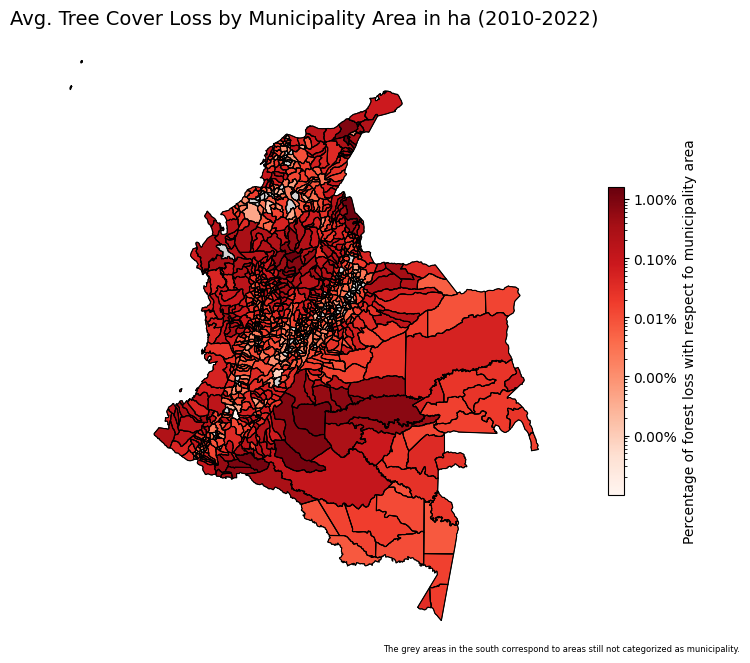

In [290]:
###############################
### Aggregate Deforestation ###
###############################

# Aggregate Tree Cover Loss by Municipality
avg_tc_loss = final_df.groupby("codmpio")["pc_loss"].mean().reset_index()

# Merge Data and Ensure Geometry is Valid
gdf = shapes.merge(avg_tc_loss, on="codmpio", how="left")

# Ensure `gdf` is a GeoDataFrame
gdf = gpd.GeoDataFrame(gdf, geometry="geometry")

# Drop rows where geometry is missing or invalid
gdf = gdf.dropna(subset=["geometry"])
gdf = gdf[gdf.is_valid]  # Remove invalid geometries


# Replace 0 with NA to avoid log(0) in the color mapping
gdf["pc_loss"] = gdf["pc_loss"].replace(0, np.nan)  # Replace 0 with NA
# Define log scale normalization for color mapping
#legend_ticks = [0.01, 0.1, 1, 5, 10]  # Adjust based on max value (14%)
log_norm = mcolors.LogNorm(vmin=gdf["pc_loss"].min(), vmax=gdf["pc_loss"].max())

fig, ax = plt.subplots(figsize=(12, 8))

shapes.plot(ax=ax, linewidth=0.8, color="lightgrey")  # Outline for all municipalities
shapes.boundary.plot(ax=ax, linewidth=0.8, color="black")

gdf.plot(column="pc_loss", cmap="Reds", linewidth=0.5, edgecolor="black",
         legend=True, ax=ax, norm=log_norm,
         missing_kwds={"color": "lightgrey", "label": "No Data"},
         legend_kwds={"label": "Percentage of forest loss with respect fo municipality area", "orientation": "vertical", 
                      "shrink": 0.5, "format": "%.2f%%"})  


ax.set_title("Avg. Tree Cover Loss by Municipality Area in ha (2010-2022)", fontsize=14)
ax.axis("off")  # Hide axes

# Move legend to the bottom right corner
leg = ax.get_legend()
if leg:
    leg.set_bbox_to_anchor((0.95, 0.05))  # (X, Y) position in figure coordinates

# Add footnote about missing data
plt.annotate("The grey areas in the south correspond to areas still not categorized as municipality.", xy=(1, 0), xycoords="axes fraction",
             fontsize=6, ha="center", va="center", color="black")

plt.show()

C:\Users\cpedr\AppData\Local\Temp\ipykernel_19204\807452563.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["centroid"] = gdf.geometry.centroid
C:\Users\cpedr\AppData\Local\Temp\ipykernel_19204\807452563.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["x"] = gdf.centroid.x
C:\Users\cpedr\AppData\Local\Temp\ipykernel_19204\807452563.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["y"] = gdf.centroid.y
c:\Users\cpedr\anaconda3\envs\nlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows

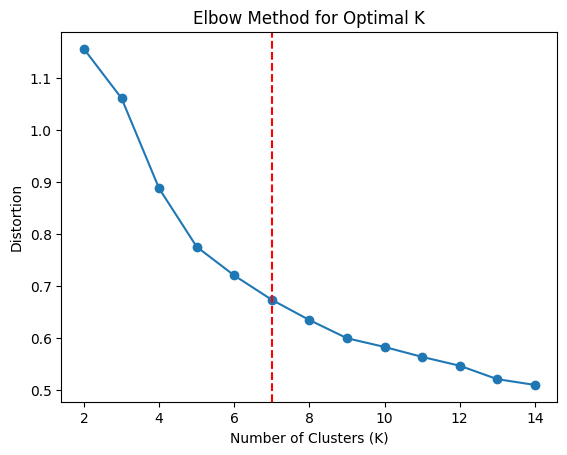

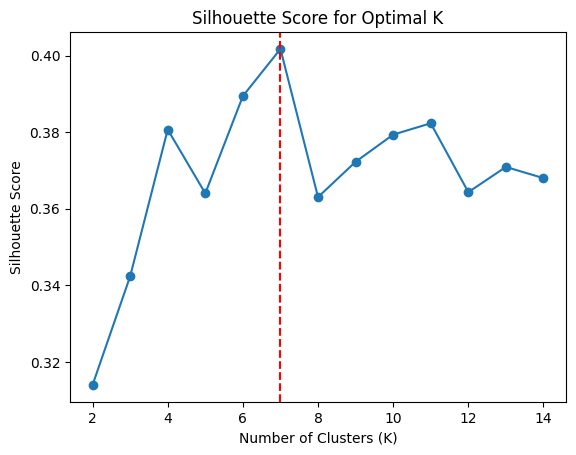

C:\Users\cpedr\AppData\Local\Temp\ipykernel_19204\807452563.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


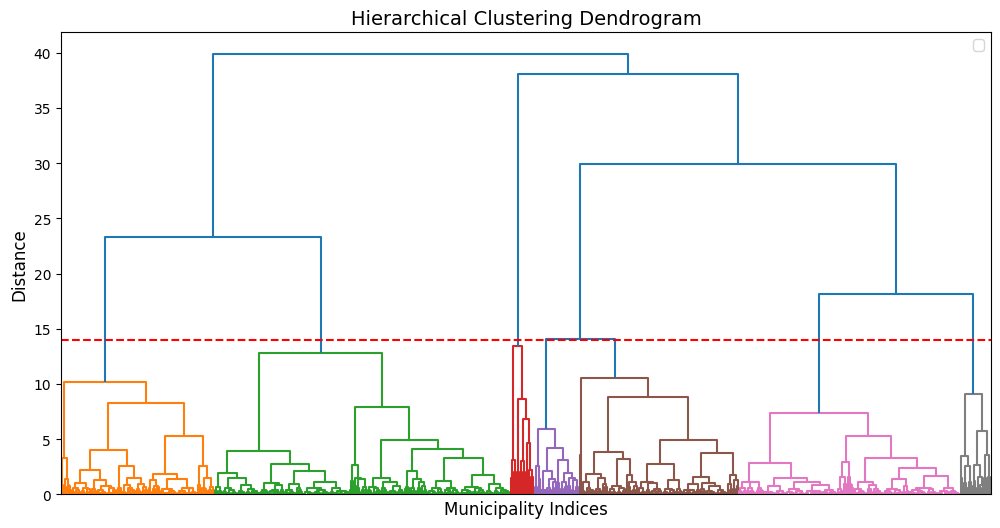

In [291]:
######################
### Clustering 2.0 ### --------------> ESTE FUNCIONA MEJOR
######################

# Pivot the data so each row is a municipality and each column is a year
deforestation_wide = final_df.pivot(index=["codmpio", 'geometry'], columns="year", values="pc_loss").fillna(0)

# Compute the average deforestation per municipality across all years
deforestation_wide["avg_deforestation"] = deforestation_wide.mean(axis=1)

# Select only the relevant columns (municipality, geometry, avg_deforestation)
deforestation_avg = deforestation_wide[["avg_deforestation"]].reset_index()

# Merge with the municipality geometries
gdf = shapes.merge(deforestation_avg, on="codmpio", how="left")

# Ensure No NaNs Before Clustering
gdf["avg_deforestation"] = gdf["avg_deforestation"].fillna(0)

# Convert to GeoDataFrame (Ensure it's recognized as a GeoDataFrame)
gdf = gpd.GeoDataFrame(gdf, geometry="geometry_x")

# Extract Centroids (Spatial Features)
gdf["centroid"] = gdf.geometry.centroid
gdf["x"] = gdf.centroid.x
gdf["y"] = gdf.centroid.y

# ✅ Select Features for Clustering (Spatial + Avg Deforestation)
features = gdf[["x", "y", "avg_deforestation"]].values

# Normalize Features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

######################
### Find Optimal K ###
######################

distortions = []
silhouette_scores = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(normalized_features)
    
    # Compute Distortion (Elbow Method)
    distortions.append(sum(np.min(cdist(normalized_features, kmeans.cluster_centers_, 'euclidean'), axis=1)) / normalized_features.shape[0])
    
    # Compute Silhouette Score
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(normalized_features, labels))

# Plot the Elbow Curve
plt.plot(K_range, distortions, marker="o")
plt.axvline(x=7, color='r', linestyle='--', label="Optimal K = 7")  # Add vertical line
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Distortion")
plt.title("Elbow Method for Optimal K")
plt.show()

# Plot Silhouette Score
plt.plot(K_range, silhouette_scores, marker="o")
plt.axvline(x=7, color='r', linestyle='--', label="Optimal K = 7")  # Add vertical line
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal K")
plt.show()

###############################
### Hierarchical Clustering ###
###############################

# Compute the linkage matrix
linkage_matrix = linkage(normalized_features, method="ward")

# Plot the dendrogram
fig, ax = plt.subplots(figsize=(12, 6))
dendrogram(
    linkage_matrix,
    ax=ax,
    no_labels=True,  # Removes individual labels (avoid clutter)
    color_threshold=14  # Colors branches below y=14 differently
)

# Add a horizontal line at y=14 to indicate clustering threshold
ax.axhline(y=14, color='r', linestyle='--')

# Improve x-axis: Reduce clutter by using a subset of indices
ax.set_xticks([])  # Hide x-axis labels since too many municipalities cause clutter

# Titles and labels
ax.set_title("Hierarchical Clustering Dendrogram", fontsize=14)
ax.set_xlabel("Municipality Indices", fontsize=12)
ax.set_ylabel("Distance", fontsize=12)

# Show legend
ax.legend()

plt.show()


c:\Users\cpedr\anaconda3\envs\nlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


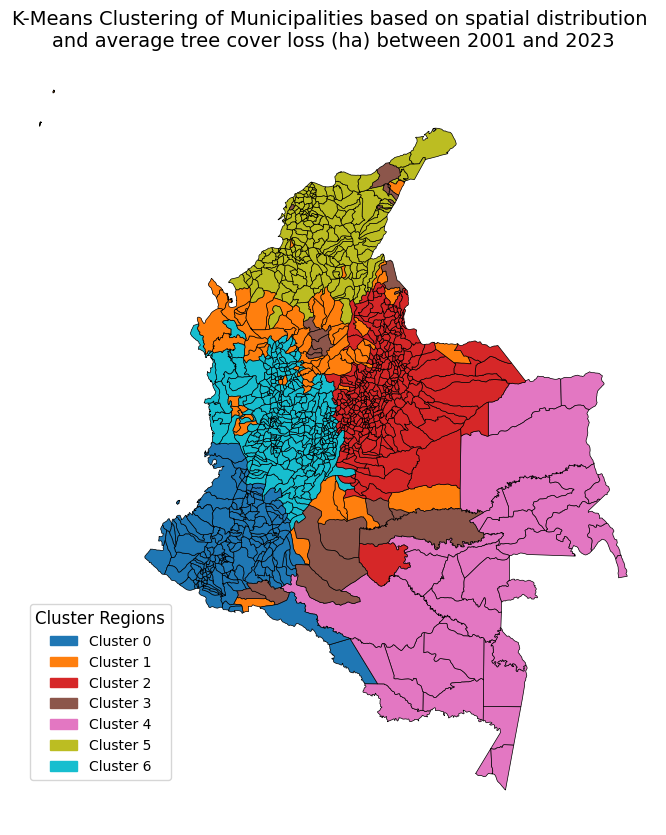

In [292]:
# Apply K-Means Clustering (Choose the best K)
optimal_k = 7   # Adjust based on elbow method result
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
gdf["cluster_kmeans"] = kmeans.fit_predict(normalized_features)


# Get unique clusters and colors
unique_clusters = sorted(gdf["cluster_kmeans"].unique())  # Ensure clusters are sorted
colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))  # Generate colors for clusters

# Create legend handles for clusters
handles = [mpatches.Patch(color=colors[i], label=f"Cluster {unique_clusters[i]}") 
           for i in range(len(unique_clusters))]

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column="cluster_kmeans", cmap="tab10", linewidth=0.5, edgecolor="black", legend=False, ax=ax)

# Add the manually created legend
ax.legend(handles=handles, title="Cluster Regions", loc="lower left",
          fontsize=10, title_fontsize=12, frameon=True,
          bbox_to_anchor=(0.02, 0.05))

# Set title
ax.set_title("K-Means Clustering of Municipalities based on spatial distribution \nand average tree cover loss (ha) between 2001 and 2023", fontsize=14)

# Remove axis borders
ax.axis("off")

plt.show()

# 3. Final merging dataset

In [293]:
##############################
### Merging final datasets ###
##############################

# Select gdf columns
gdf = gdf[["codmpio", "cluster_kmeans"]]

# Merge gdf with final_df
final_merge = gdf.merge(final_df, on="codmpio", how="left")

# Sort the dataset by `codmpio` and `year`
final_merge = final_merge.sort_values(by=["codmpio", "year"]).reset_index(drop=True)
del final_merge["geometry"]
final_merge

,codmpio,cluster_kmeans,Departamento,Municipio,Region,year,f_loss,pc_loss,areaoficialhm2,gdp,...,P-01-25,PCC-01-2,PCC-02-1,C-03-14,PCC-02-3,PCC-02-3a,PCC-02-4,C-03-13,P-01-46,P-01-34-1
0,5001.0,6,ANTIOQUIA,MEDELLIN,Andina,2010.0,30.154418,0.077918,38700.0,2.964083e+07,...,1.0,45.165549,100.0,12.590432,99.751839,100.000000,50.000000,1.0,1.217692,4.0
1,5001.0,6,ANTIOQUIA,MEDELLIN,Andina,2011.0,25.695615,0.066397,38700.0,3.444253e+07,...,1.0,45.245880,100.0,12.920759,99.751839,100.000000,50.000000,1.0,1.217692,4.0
2,5001.0,6,ANTIOQUIA,MEDELLIN,Andina,2012.0,29.345245,0.075828,38700.0,3.692472e+07,...,1.0,46.737400,100.0,11.617163,99.751839,100.000000,50.000000,1.0,1.217692,4.0
3,5001.0,6,ANTIOQUIA,MEDELLIN,Andina,2013.0,18.412226,0.047577,38700.0,4.088087e+07,...,1.0,50.976367,100.0,12.658621,99.751839,100.000000,50.000000,1.0,1.217692,4.0
4,5001.0,6,ANTIOQUIA,MEDELLIN,Andina,2014.0,43.509827,0.112428,38700.0,4.304234e+07,...,1.0,49.602144,100.0,11.879778,89.775347,90.355662,45.177831,1.0,1.217692,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,99773.0,4,VICHADA,CUMARIBO,Orinoquia,2018.0,5986.956176,0.091162,6567400.0,2.728310e+05,...,5.0,0.001109,0.0,0.000000,0.185979,1.158266,40.105233,1.0,3.078961,1.0
13576,99773.0,4,VICHADA,CUMARIBO,Orinoquia,2019.0,5318.000000,0.080976,6567400.0,2.756950e+05,...,5.0,0.001075,0.0,2.469746,0.091892,0.450848,29.522425,1.0,3.078961,1.0
13577,99773.0,4,VICHADA,CUMARIBO,Orinoquia,2020.0,3986.000000,0.060694,6567400.0,2.766593e+05,...,5.0,0.001052,0.0,2.412022,0.117194,0.502259,29.548131,1.0,3.078961,1.0
13578,99773.0,4,VICHADA,CUMARIBO,Orinoquia,2021.0,3702.330583,0.056374,6567400.0,3.169662e+05,...,5.0,0.001125,0.0,0.000000,0.136256,0.458311,20.455470,1.0,3.078961,1.0


In [294]:
# Define file names
csv_filename = "../final_df.csv"
zip_filename = "../final_df.zip"

# Save the DataFrame as a CSV file
final_merge.to_csv(csv_filename, index=False)

# Compress the CSV file into a ZIP archive
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(csv_filename)

# Delete the original CSV file after zipping
os.remove(csv_filename)

# 3.1. Additional imputation

In [295]:
# Define file names
csv_filename = "../final_df.csv"
zip_filename = "../final_df.zip"

# Extract the CSV file from the ZIP
with zipfile.ZipFile(zip_filename, 'r') as zipf:
    zipf.extract(csv_filename)

# Read the CSV file into a DataFrame
final_df = pd.read_csv("final_df.csv")

# Delete the extracted CSV file after reading
os.remove("final_df.csv")

final_df

,codmpio,cluster_kmeans,Departamento,Municipio,Region,year,f_loss,pc_loss,areaoficialhm2,gdp,...,P-01-25,PCC-01-2,PCC-02-1,C-03-14,PCC-02-3,PCC-02-3a,PCC-02-4,C-03-13,P-01-46,P-01-34-1
0,5001.0,6,ANTIOQUIA,MEDELLIN,Andina,2010.0,30.154418,0.077918,38700.0,2.964083e+07,...,1.0,45.165549,100.0,12.590432,99.751839,100.000000,50.000000,1.0,1.217692,4.0
1,5001.0,6,ANTIOQUIA,MEDELLIN,Andina,2011.0,25.695615,0.066397,38700.0,3.444253e+07,...,1.0,45.245880,100.0,12.920759,99.751839,100.000000,50.000000,1.0,1.217692,4.0
2,5001.0,6,ANTIOQUIA,MEDELLIN,Andina,2012.0,29.345245,0.075828,38700.0,3.692472e+07,...,1.0,46.737400,100.0,11.617163,99.751839,100.000000,50.000000,1.0,1.217692,4.0
3,5001.0,6,ANTIOQUIA,MEDELLIN,Andina,2013.0,18.412226,0.047577,38700.0,4.088087e+07,...,1.0,50.976367,100.0,12.658621,99.751839,100.000000,50.000000,1.0,1.217692,4.0
4,5001.0,6,ANTIOQUIA,MEDELLIN,Andina,2014.0,43.509827,0.112428,38700.0,4.304234e+07,...,1.0,49.602144,100.0,11.879778,89.775347,90.355662,45.177831,1.0,1.217692,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,99773.0,4,VICHADA,CUMARIBO,Orinoquia,2018.0,5986.956176,0.091162,6567400.0,2.728310e+05,...,5.0,0.001109,0.0,0.000000,0.185979,1.158266,40.105233,1.0,3.078961,1.0
13576,99773.0,4,VICHADA,CUMARIBO,Orinoquia,2019.0,5318.000000,0.080976,6567400.0,2.756950e+05,...,5.0,0.001075,0.0,2.469746,0.091892,0.450848,29.522425,1.0,3.078961,1.0
13577,99773.0,4,VICHADA,CUMARIBO,Orinoquia,2020.0,3986.000000,0.060694,6567400.0,2.766593e+05,...,5.0,0.001052,0.0,2.412022,0.117194,0.502259,29.548131,1.0,3.078961,1.0
13578,99773.0,4,VICHADA,CUMARIBO,Orinoquia,2021.0,3702.330583,0.056374,6567400.0,3.169662e+05,...,5.0,0.001125,0.0,0.000000,0.136256,0.458311,20.455470,1.0,3.078961,1.0


In [296]:
# Get rid of rows with all NaN values
final_df = final_df[~final_df[final_df.columns[2:]].isna().all(axis=1)]


In [299]:
# Calculate % of missing values per column
na_percent = final_df.isna().mean() * 100

# Filter only columns with missing values
na_summary = na_percent[na_percent > 0].sort_values(ascending=False).reset_index()
na_summary.columns = ['Variable', 'Percentage_NA']

# Round for cleaner display
na_summary['Percentage_NA'] = na_summary['Percentage_NA'].round(2)

na_summary


,Variable,Percentage_NA


In [298]:
# Fill NAs with 0 for cases with 0 events
group_zero_cols = ["eventos_minas", "e_vinc_mened", "e_tortura", "e_minas_anti", "e_desplaza", "e_desap_for", "e_confina",
                   "e_amenaza", "pirateria_terr", "terrorismot", "errad_manual", "H_coca", "e_delito_sex", "C-02-8t",
                   "total_ac", "total_as", "total_p", "total_r", "total_nuf", "total_vrf", "M-03-24"]

for col in group_zero_cols:
    final_df[col] = final_df[col].fillna(0)

# Fill first using interpolation, then departmental mean, then national median
group_inter_cols = [var for var in na_summary['Variable'] if var not in group_zero_cols]

for col in group_inter_cols:
    # Step 1: Interpolate by municipality
    col_interp = final_df.groupby("codmpio")[col].transform(lambda x: x.interpolate().ffill().bfill())

    # Step 2: Validity checks at department level
    total_munis = final_df.groupby("Departamento")["codmpio"].nunique()
    valid_munis = final_df[~col_interp.isna()].groupby("Departamento")["codmpio"].nunique()
    prop_valid = (valid_munis / total_munis).fillna(0)
    depts_ok = prop_valid[prop_valid >= 0.5].index

    # Step 3: Department mean (only for good departments)
    dept_mean = final_df.groupby("Departamento")[col].transform("mean")
    use_dept_mean = final_df["Departamento"].isin(depts_ok)

    # Step 4: Fill with department mean
    col_filled = col_interp.where(~col_interp.isna(), other=np.where(use_dept_mean, dept_mean, np.nan))

    # Step 5: Fill with regional value if still missing
    # You can choose mean or median here
    regional_stat = final_df.groupby("Region")[col].transform("median")  # or "mean"
    col_filled = col_filled.fillna(regional_stat)

    # Step 6: Final fallback → national median
    final_df[col] = col_filled.fillna(final_df[col].median())


C:\Users\cpedr\AppData\Local\Temp\ipykernel_19204\1757849313.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[col] = final_df[col].fillna(0)
C:\Users\cpedr\AppData\Local\Temp\ipykernel_19204\1757849313.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[col] = col_filled.fillna(final_df[col].median())
C:\Users\cpedr\AppData\Local\Temp\ipykernel_19204\1757849313.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [307]:
# Define file names
csv_filename = "../final_df.csv"
zip_filename = "../final_df.zip"

# Save the DataFrame as a CSV file
final_df.to_csv(csv_filename, index=False)

# Compress the CSV file into a ZIP archive
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(csv_filename)

# Delete the original CSV file after zipping
os.remove(csv_filename)

In [306]:
final_df.isna().sum().sum()

0

# 4. Additional graphs for visualization

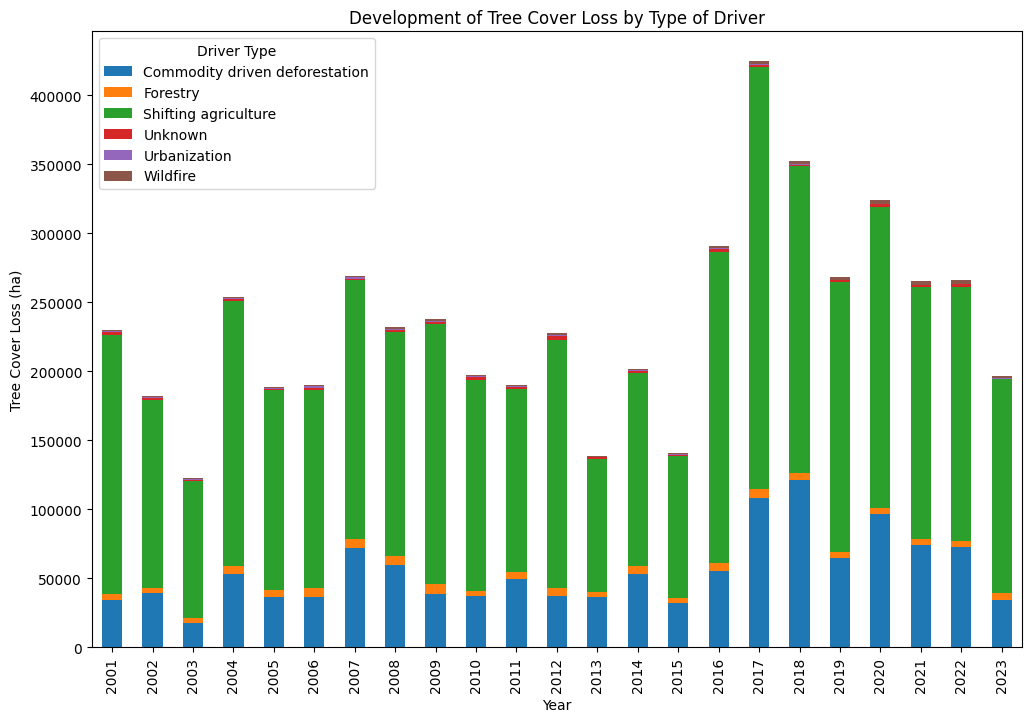

In [82]:
#######################################
### Deforestation by type of driver ###
#######################################

# Deforestation data by type of driver
df_deforestation = dataframes[3]

# Pivot the dataframe to have years as index and types as columns
df_pivot = df_deforestation.pivot(index='umd_tree_cover_loss__year', columns='tsc_tree_cover_loss_drivers__driver', values='umd_tree_cover_loss__ha')

# Plot the bar graph
df_pivot.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Development of Tree Cover Loss by Type of Driver')
plt.xlabel('Year')
plt.ylabel('Tree Cover Loss (ha)')
plt.legend(title='Driver Type')
plt.show()

In [83]:
# Calculate the total tree cover loss by year
df_pivot['Total'] = df_pivot.sum(axis=1)

# Calculate the percentage of "Shifting agriculture" for each year
df_pivot['Shifting_agriculture_percentage'] = (df_pivot['Shifting agriculture'] / df_pivot['Total']) * 100

# Calculate the average percentage of "Shifting agriculture"
average_shifting_agriculture_percentage = df_pivot['Shifting_agriculture_percentage'].mean()

print(f"Average percentage of Shifting agriculture: {average_shifting_agriculture_percentage:.2f}%")

Average percentage of Shifting agriculture: 73.50%


In [364]:
missing = shapes[shapes["codmpio"] == 27086]
missing["Region"] = "Pacifica"
missing["depto"] = "Chocó"

c:\Users\cpedr\anaconda3\envs\nlp\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\cpedr\anaconda3\envs\nlp\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [365]:
regions = general[["codmpio", "Region"]]
regions = regions.merge(dataframes[5][["codmpio", "depto"]], on= "codmpio")
regions = regions.drop_duplicates(subset = ["codmpio", "Region"])
regions = pd.concat([regions, missing])

gdf_new = shapes.merge(regions, on="codmpio")
del gdf_new["geometry_y"]
gdf_new = gdf_new.rename(columns= {
    "geometry_x": "geometry"
}) 
gdf_new =  gpd.GeoDataFrame(gdf_new, geometry= "geometry")

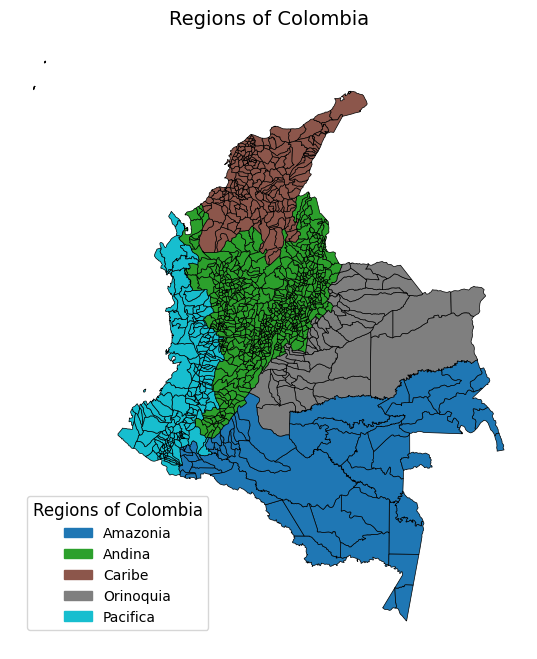

In [366]:
# Plot the map for regions
fig, ax = plt.subplots(figsize=(12, 8))
gdf_new.plot(column="Region", cmap="tab10", linewidth=0.5, edgecolor="black", legend=True, ax=ax)

# Get unique clusters and colors
unique_regions = sorted(gdf_new["Region"].unique())  # Ensure regions are sorted
colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_regions)))  # Generate colors for regions

# Create legend handles for regions
handles = [mpatches.Patch(color=colors[i], label=f"{unique_regions[i]}") 
           for i in range(len(unique_regions))]

# Add the manually created legend
ax.legend(handles=handles, title="Regions of Colombia", loc="lower left",
          fontsize=10, title_fontsize=12, frameon=True,
          bbox_to_anchor=(0.02, 0.02))

# Set title
ax.set_title("Regions of Colombia", fontsize=14)

# Remove axis borders
ax.axis("off")

plt.show()

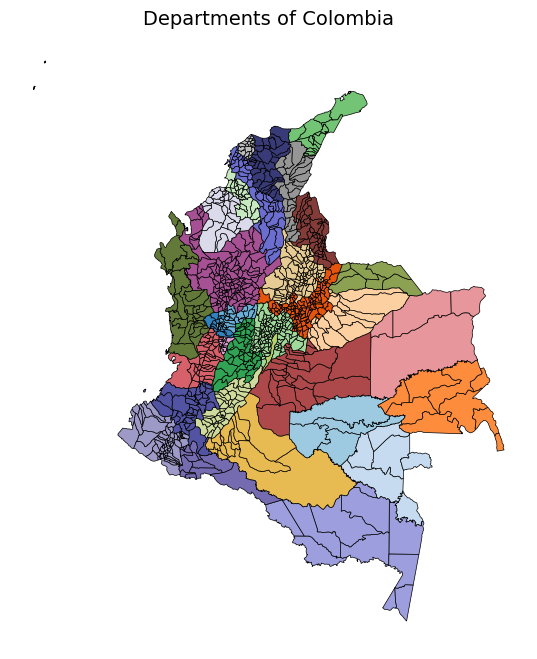

In [367]:
# Map for departments --------------> DE PRONTO NO CONVIENE POR LA CANTIDAD DE DEPARTAMENTOS

# Set a fixed seed to ensure the same colors are selected every time
random.seed(123)

# Extract 20 colors from 'tab20b' and 'tab20c' (total of 40)
colors_tab20b = [plt.cm.tab20b(i/20) for i in range(20)]
colors_tab20c = [plt.cm.tab20c(i/20) for i in range(20)]

# Combine both color lists
all_colors = colors_tab20b + colors_tab20c  # 40 total colors

# Randomly select 33 unique colors
selected_colors = random.sample(all_colors, 33)

# Convert to a colormap
custom_cmap = ListedColormap(selected_colors)


# Plot the map for regions
fig, ax = plt.subplots(figsize=(12, 8))
gdf_new.plot(column="depto", cmap=custom_cmap, linewidth=0.5, edgecolor="black", legend=False, ax=ax)

# Set title
ax.set_title("Departments of Colombia", fontsize=14)

# Remove axis borders
ax.axis("off")

plt.show()

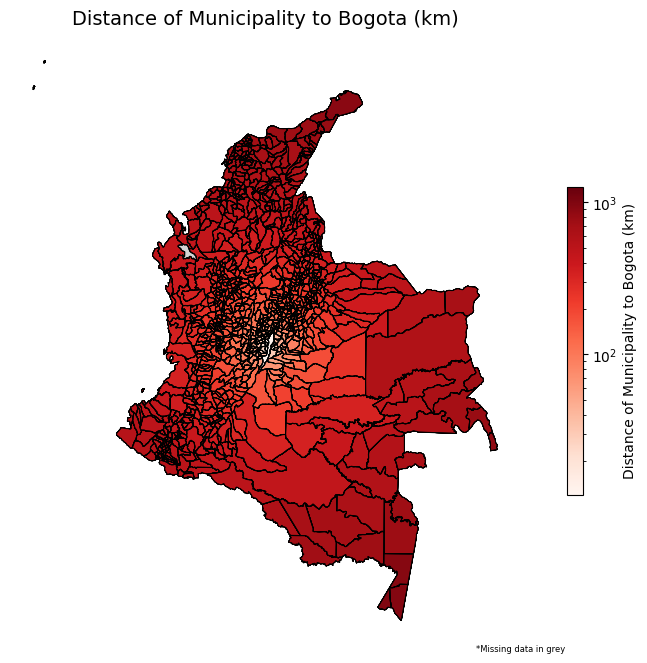

In [262]:
#####################
### Distance maps ###
#####################

# Define file names
csv_filename = "../final_df.csv"
zip_filename = "../final_df.zip"

# Extract the CSV file from the ZIP
with zipfile.ZipFile(zip_filename, 'r') as zipf:
    zipf.extract(csv_filename)

# Read the CSV file into a DataFrame
final_df = pd.read_csv("final_df.csv")

# Delete the extracted CSV file after reading
os.remove("final_df.csv")  

# Ensure the 'mpios' column in shapes is of type float to match 'codmpio' in final_df
shapes['codmpio'] = shapes['codmpio'].astype(float)

# Merge the final_df with the shapes dataset
final_shp = shapes.merge(final_df, on='codmpio', how='left')
final_shp = gpd.GeoDataFrame(final_shp, geometry='geometry')

# Map: Distance to Bogota    

# Replace 0 with 1e-6 to avoid log(0) in the color mapping
final_shp["disbogota"] = final_shp["disbogota"].replace(0, 1e-6)  # Replace 0 with 1e-6
# Define log scale normalization for color mapping
log_norm = mcolors.LogNorm(vmin=final_shp["disbogota"][final_shp["disbogota"] > 1e-6].min(), 
                           vmax=final_shp["disbogota"].max())

fig, ax = plt.subplots(figsize=(12, 8))

shapes.plot(ax=ax, linewidth=0.8, color="lightgrey")  # Outline for all municipalities
shapes.boundary.plot(ax=ax, linewidth=0.8, color="black")

final_shp.plot(column="disbogota", cmap="Reds", linewidth=0.5, edgecolor="black",
         legend=True, ax=ax, norm=log_norm,
         missing_kwds={"color": "lightgrey", "label": "No Data"},
         legend_kwds={"label": "Distance of Municipality to Bogota (km)", "orientation": "vertical", "shrink": 0.5})  # Shrink legend size


ax.set_title("Distance of Municipality to Bogota (km)", fontsize=14)
ax.axis("off")  # Hide axes

# Move legend to the bottom right corner
leg = ax.get_legend()
if leg:
    leg.set_bbox_to_anchor((0.95, 0.05))  # (X, Y) position in figure coordinates

# Add footnote about missing data
plt.annotate("*Missing data in grey", xy=(1, 0), xycoords="axes fraction",
             fontsize=6, ha="center", va="center", color="black")

plt.show()


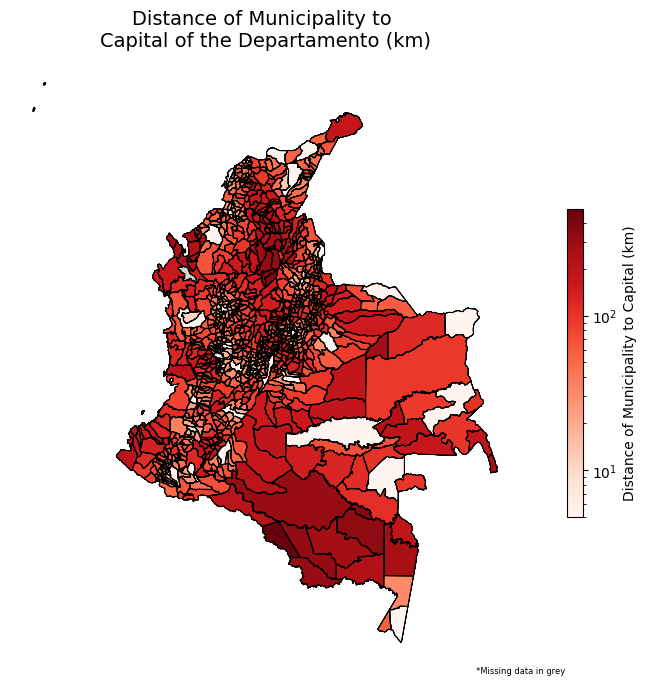

In [263]:
# Map: Distance to Capital

# Replace 0 with 1e-6 to avoid log(0) in the color mapping
final_shp["discapital"] = final_shp["discapital"].replace(0, 1e-6)  # Replace 0 with 1e-6
# Define log scale normalization for color mapping
log_norm = mcolors.LogNorm(vmin=final_shp["discapital"][final_shp["discapital"] > 1e-6].min(), 
                           vmax=final_shp["discapital"].max())

fig, ax = plt.subplots(figsize=(12, 8))

shapes.plot(ax=ax, linewidth=0.8, color="lightgrey")  # Outline for all municipalities
shapes.boundary.plot(ax=ax, linewidth=0.8, color="black")

final_shp.plot(column="discapital", cmap="Reds", linewidth=0.5, edgecolor="black",
         legend=True, ax=ax, norm=log_norm,
         missing_kwds={"color": "lightgrey", "label": "No Data"},
         legend_kwds={"label": "Distance of Municipality to Capital (km)", "orientation": "vertical", "shrink": 0.5})  # Shrink legend size


ax.set_title("Distance of Municipality to \nCapital of the Departamento (km)", fontsize=14)
ax.axis("off")  # Hide axes

# Move legend to the bottom right corner
leg = ax.get_legend()
if leg:
    leg.set_bbox_to_anchor((0.95, 0.05))  # (X, Y) position in figure coordinates

# Add footnote about missing data
plt.annotate("*Missing data in grey", xy=(1, 0), xycoords="axes fraction",
             fontsize=6, ha="center", va="center", color="black")

plt.show()

c:\Users\cpedr\anaconda3\envs\nlp\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


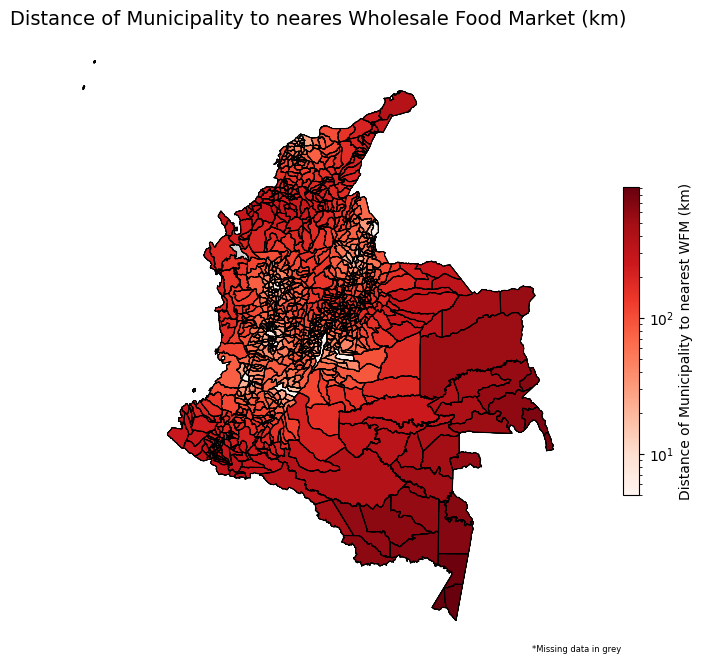

In [264]:
# Map: Distance to nearest wholesale food market

# Replace 0 with 1e-6 to avoid log(0) in the color mapping
# Drop observations where 'dismdo' is NaN
final_shp = final_shp.dropna(subset=["dismdo"])

final_shp["dismdo"] = final_shp["dismdo"].replace(0, 1e-6)  # Replace 0 with 1e-6
# Define log scale normalization for color mapping
log_norm = mcolors.LogNorm(vmin=final_shp["dismdo"][final_shp["dismdo"] > 1e-6].min(), 
                           vmax=final_shp["dismdo"].max())

fig, ax = plt.subplots(figsize=(12, 8))

shapes.plot(ax=ax, linewidth=0.8, color="lightgrey")  # Outline for all municipalities
shapes.boundary.plot(ax=ax, linewidth=0.8, color="black")

final_shp.plot(column="dismdo", cmap="Reds", linewidth=0.5, edgecolor="black",
         legend=True, ax=ax, norm=log_norm,
         missing_kwds={"color": "lightgrey", "label": "No Data"},
         legend_kwds={"label": "Distance of Municipality to nearest WFM (km)", "orientation": "vertical", "shrink": 0.5})  # Shrink legend size


ax.set_title("Distance of Municipality to neares Wholesale Food Market (km)", fontsize=14)
ax.axis("off")  # Hide axes

# Move legend to the bottom right corner
leg = ax.get_legend()
if leg:
    leg.set_bbox_to_anchor((0.95, 0.05))  # (X, Y) position in figure coordinates

# Add footnote about missing data
plt.annotate("*Missing data in grey", xy=(1, 0), xycoords="axes fraction",
             fontsize=6, ha="center", va="center", color="black")

plt.show()